In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
## free cuda memory
torch.cuda.empty_cache()

In [3]:
SOS_token = 0
EOS_token = 1
UNK_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = { "SOS": 0,"EOS":1,"UNK":2}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS",2:"UNK"}
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    # Remove ?, :, and !
    s = re.sub(r"[?:!()]+", r"", s)
    s = re.sub(r"[^a-zA-Z]+", r" ", s)  # Remove characters other than letters
    return s.strip()

In [5]:
import pandas as pd

def readLangs(file, reverse=False):
    print("Reading lines...")
        # Read the CSV file into a DataFrame
    df = pd.read_csv(f'./{file}_combined.csv', encoding='utf-8')

    # Extract pairs from DataFrame columns
    pairs = df.values.tolist()

    pairs = [[normalizeString(str(s)) for s in pair] for pair in pairs]

    lang1 = 'eng'
    lang2='hing'
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
_,_,pairs = readLangs('train', False)


Reading lines...


In [7]:
def analyze_probability_distribution(pairs):
    lengths_src = [len(sentence.split()) for sentence,b in pairs]
    lengths_trg = [len(b.split()) for sentence,b in pairs]
    lengths = lengths_src + lengths_trg
    max_length = max(lengths)
    min_length = min(lengths)
    avg_length = sum(lengths) / len(lengths)
    
    # Calculate frequency of occurrence for each length
    length_freq = {}
    for length in lengths:
        length_freq[length] = length_freq.get(length, 0) + 1
    
    # Calculate probability distribution
    total_samples = 2*len(pairs)
    length_probs = {length: freq / total_samples for length, freq in length_freq.items()}
    
    return max_length, min_length, avg_length, length_probs


In [8]:
print(analyze_probability_distribution(pairs))

(340, 0, 11.280476456355853, {1: 0.0691109870339351, 5: 0.07332961101805323, 15: 0.029034059184812954, 4: 0.06483032446181525, 12: 0.03753334574105093, 2: 0.043427011601215953, 20: 0.015385569824430796, 22: 0.01340033500837521, 8: 0.06272101246975618, 24: 0.010174328432284881, 3: 0.04088342949314474, 0: 0.0042186239841181215, 26: 0.00911967243625535, 11: 0.04677709535330976, 6: 0.06898690985793163, 18: 0.020100502512562814, 13: 0.035175879396984924, 27: 0.006700167504187605, 14: 0.030771139648861592, 10: 0.0463428252372976, 19: 0.01594391711644643, 23: 0.0110428686643092, 7: 0.06377566846578572, 17: 0.022023698740616663, 36: 0.0026056206960729574, 31: 0.004094546808114647, 41: 0.0020472734040573237, 37: 0.0026056206960729574, 9: 0.05248464544946957, 21: 0.013462373596376946, 16: 0.024939512376698305, 32: 0.004094546808114647, 25: 0.007630746324213661, 28: 0.005335318568149389, 34: 0.004839009864135492, 30: 0.0042186239841181215, 38: 0.0024815435200694833, 33: 0.003163967988088591, 40: 

In [9]:
MAX_LENGTH = 11

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [10]:
def prepareData(file, reverse=False):
    input_lang, output_lang, pairs = readLangs(file, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1,dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers,batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size,num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size,num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [13]:
def indexesFromSentence(lang, sentence):
    words =[]
    for word in sentence.split(' '):
        if word in lang.word2index:
            words.append(word)
        else:
            words.append('UNK')
    return [lang.word2index[word] for word in words]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def get_dataloader(file,batch_size):
    input_lang, output_lang, pairs = prepareData(file, False)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader,pairs

In [14]:
weights = [(1, 0, 0, 0), (0.5, 0.5), (0.33, 0.33, 0.33, 0), (0.25, 0.25, 0.25, 0.25),(0.2,0.2,0.2,0.2,0.2),(0.16,0.16,0.16,0.16,0.16,0.16),(0.14,0.14,0.14,0.14,0.14,0.14,0.14),(0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125)]
len(weights)

8

In [15]:
from nltk.translate.bleu_score import sentence_bleu

def bleu_score(references, candidates): # type: ignore
    score = [0]*len(weights)
    for i in range(len(references)):
        for j,w in enumerate(weights):
            ref_tokens = references[i].split()
            can_tokens = candidates[i].split()
            temp_score = sentence_bleu([ref_tokens], can_tokens, weights=w)
            # add temp score truncated to 2 decimal places to score[j]
            score[j] += temp_score # type: ignore
    for i in range(len(score)):
        score[i] = score[i]/len(references) # type: ignore
        score[i] = round(score[i],6)
    return score



In [16]:
def train_bleuscore(input_tensor,decoder_outputs,input_lang, output_lang):
    input_words = []
    for idx in input_tensor:
        temp=[]
        for i in idx:
            temp.append(input_lang.index2word[i.item()])
        temp = ' '.join(temp)
        input_words.append(temp)
        
    _, topi = decoder_outputs.topk(1)
    decoded_ids = topi.squeeze()
    decoded_words = []
    for idx in decoded_ids:
        temp = []
        for i in idx:
            if i.item() == EOS_token:
                temp.append('<EOS>')
                break
            temp.append(output_lang.index2word[i.item()])
        temp = ' '.join(temp)
        decoded_words.append(temp)
    bleu = bleu_score(input_words,decoded_words)
    return bleu
    
    

In [17]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [19]:

def train_epoch(dataloader, input_lang, output_lang, encoder, decoder, encoder_optimizer,
                decoder_optimizer, criterion, type="train"):
    total_loss = 0
    blues = []
    
    for data in dataloader:
        input_tensor, target_tensor = data
        
        if type == "train":
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        
        bleu = train_bleuscore(input_tensor, decoder_outputs, input_lang, output_lang)
        blues.append(bleu)
        
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        
        if type == "train":
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
    
        total_loss += loss.item()

    return total_loss / len(dataloader), np.mean(blues, axis=0)


In [20]:
def train(train_dataloader,val_dataloader,input_lang,output_lang, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):

    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    blues = []
    blues_val = []
    plot_losses_val = []
    print_loss_total_val = 0  # Reset every print_every
    plot_loss_total_val = 0  # Reset every plot_every
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        encoder.train()
        decoder.train()
        loss,blue = train_epoch(train_dataloader,input_lang,output_lang, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        encoder.eval()
        decoder.eval()
        loss_val,bleu_val = train_epoch(val_dataloader,input_lang,output_lang, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion,"val")
        print_loss_total_val += loss_val
        plot_loss_total_val += loss_val
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print_loss_avg_val = print_loss_total_val / print_every
            print_loss_total_val = 0
            print(f'{timeSince(start, epoch / n_epochs)} ({epoch / n_epochs * 100:.2f}%) Train Loss: {print_loss_avg:.4f} Val Loss: {print_loss_avg_val:.4f}')

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            plot_loss_avg_val = plot_loss_total_val / plot_every
            plot_losses_val.append(plot_loss_avg_val)
            plot_loss_total_val = 0
            blues_val.append(bleu_val)
            blues.append(blue)

    return blues,blues_val,plot_losses,plot_losses_val

In [21]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [22]:
hidden_size = 128
batch_size = 64

input_lang, output_lang, train_dataloader,pairs = get_dataloader('train',batch_size)
print("=====================================")
_,_,val_dataloader,pairs_val = get_dataloader('val',batch_size)
print("=====================================")
_,_,test_dataloader,pairs_test = get_dataloader('test',batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

bleus,bleus_val,losses,losses_val=train(train_dataloader,val_dataloader,input_lang,output_lang, encoder, decoder, 80,0.1, print_every=5, plot_every=1)

Reading lines...
Read 16119 sentence pairs
Counting words...
Counted words:
eng 2237
hing 3566
Reading lines...
Read 1883 sentence pairs
Counting words...
Counted words:
eng 613
hing 852
Reading lines...
Read 960 sentence pairs
Counting words...
Counted words:
eng 632
hing 913
1m 21s (- 20m 28s) (6.25%) Train Loss: 7.6857 Val Loss: 13.7029
2m 52s (- 20m 4s) (12.50%) Train Loss: 5.0823 Val Loss: 13.8359
4m 51s (- 21m 3s) (18.75%) Train Loss: 4.2555 Val Loss: 15.9803
7m 4s (- 21m 14s) (25.00%) Train Loss: 3.8194 Val Loss: 18.7248
9m 12s (- 20m 15s) (31.25%) Train Loss: 3.7517 Val Loss: 21.6482
11m 6s (- 18m 30s) (37.50%) Train Loss: 4.2210 Val Loss: 25.2755
12m 51s (- 16m 32s) (43.75%) Train Loss: 3.5954 Val Loss: 27.4052
14m 31s (- 14m 31s) (50.00%) Train Loss: 3.3597 Val Loss: 29.7631
16m 5s (- 12m 30s) (56.25%) Train Loss: 3.3520 Val Loss: 32.6210
17m 33s (- 10m 32s) (62.50%) Train Loss: 3.6511 Val Loss: 36.0754
18m 57s (- 8m 37s) (68.75%) Train Loss: 3.7149 Val Loss: 38.5833
20m 20s 

In [23]:
# ### write code for hyperparameter tuning and plotting the results
# learning_rates = [0.001,0.01,0.1]   
# batch_size = [32,64]
# hidden_size = [64,128]
# num_layer = [1,2]
# results = []
# for lr in learning_rates:
#     for bs in batch_size:
#         for hs in hidden_size:
#             for nl in num_layer:
#                 input_lang, output_lang, train_dataloader,pairs = get_dataloader('train',bs)
#                 _,_,val_dataloader,pairs_val = get_dataloader('val',bs)
#                 _,_,test_dataloader,pairs_test = get_dataloader('test',bs)
#                 encoder = EncoderRNN(input_lang.n_words, hs,nl).to(device)
#                 decoder = DecoderRNN(hs, output_lang.n_words,nl).to(device)
#                 bleus,bleus_val,losses,losses_val=train(train_dataloader,val_dataloader,input_lang,output_lang, encoder, decoder,15, lr, print_every=5, plot_every=1)
#                 print(f'Learning Rate: {lr}, Batch Size: {bs}, Hidden Size: {hs}')
#                 print(f'Train BLEU: {bleus[-1]}, Val BLEU: {bleus_val[-1]}')
#                 print(f'Train Loss: {losses[-1]}, Val Loss: {losses_val[-1]}')
#                 print("=====================================")
#                 results.append({"lr":lr,"bs":bs,"hs":hs,"train_bleu":bleus,"val_bleu":bleus_val,"train_loss":losses,"val_loss":losses_val})
                
                


In [25]:
# np.save('results_gru.npy',results)

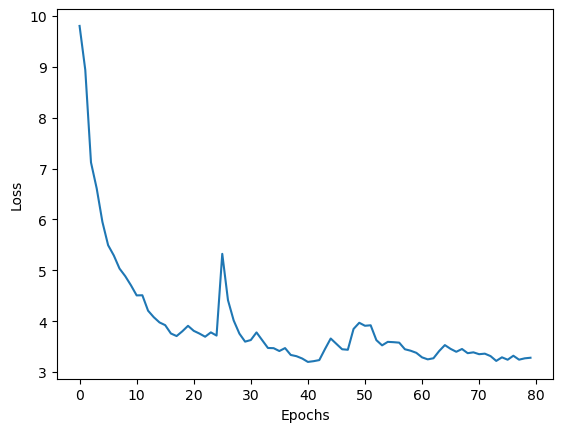

In [32]:
import matplotlib.pyplot as plt
plt.plot(losses, label='train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [33]:
def evaluate_test(encoder, decoder,pairs=pairs_test):
    candidates = []
    references = []
    inputs=[]
    for pair in pairs:
        inputs.append(pair[0])
        references.append(pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        candidates.append(output_sentence)
    return candidates,references,inputs

candidates,references,inputs = evaluate_test(encoder, decoder)

In [35]:
import pandas as pd
df = pd.DataFrame({'eng':inputs,'hing':references,'third_column':candidates})
df.to_csv('predictions_gru.csv',index=False)
print("Predictions saved to predictions_gru.csv")

Predictions saved to predictions_gru.csv


In [ ]:
score=bleu_score(references,candidates)
print(score)

np.save('candidate_test_nrml_80.npy',candidates)
np.save('references_test_nrml_80.npy',references)
np.save('bleus_full_train_nrml_80.npy',bleus)
np.save('bleus_full_val_nrml_80.npy',bleus_val)

[0.08942, 0.015402, 0.00515, 0.00236, 0.000922, 0.0, 0.0, 0.0]


In [ ]:
def evaluate_randomly(encoder,decoder,pairs,n=5):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

evaluate_randomly(encoder,decoder,pairs_test)

> no problem
= koi baat nahi
< nahi koi acchi movie nahi dekha <EOS>

> that sounds funny i like morgan freeman
= kuch funny sounds karta muje morgan freeman pasand hein
< mene karungi ki ye ek dark achchi lagi <EOS>

> do you remember your favorite scene
= kya tumhara favorite scene yaad hein kya
< aur kuch aur kuch aur questions hain <EOS>

> yes you definitely should
= haan tumhe definitely dekhna chahiye
< haan ofcourse ki tarah se kuch disappoint hein <EOS>

> i don t think mine did yet
= mujhe nahi lagta meri abhi tak hui hai
< main netflix me barosa nahi sochta ki main actor socha hi

